In [1]:
from pipeline_creation import create_pipeline, make_list_of_elements, weights_to_apply, equalize_histogram
from utils import get_random_indices, get_file_paths, get_training_files_paths, gray_svd_decomposition
from from_preprocessing_to_training import AttentionUnet, Losses
from preprocessing import LoadPreprocessImages

import matplotlib.pyplot as plt
import cv2
import json
from tqdm import tqdm
import numpy as np

import tensorflow as tf 
from tensorflow import keras
# from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from keras import backend as K

In [2]:
from transformers import TFSegformerForSemanticSegmentation

In [3]:
with open('config.json') as f:
    config = json.load(f)

In [4]:
import numpy as np
from PIL import Image

def gray_svd_decomposition(img, k):
    img_mat = np.array(img, dtype=float)
    
    # Perform Singular Value Decomposition
    U, sigma, Vt = np.linalg.svd(img_mat, full_matrices=False)
    
    # Keep only the top k singular values and vectors
    U_k = U[:, :k]
    sigma_k = np.diag(sigma[:k])
    Vt_k = Vt[:k, :]
    
    # Image reconstruction
    reconst_img = np.dot(U_k, np.dot(sigma_k, Vt_k))
    
    # Normalize the reconstructed image to [0, 255] range
    reconst_img = np.clip(reconst_img, 0, 255)
    reconst_img = np.round(reconst_img).astype(np.uint8)
    
    return reconst_img


In [5]:
class LoadPreprocessImagesBis:
    @staticmethod
    def equalize_histogram(image, convert_to_tensors=True):
        """
        Apply histogram equalization to an RGB image.

        Parameters:
        - image (tf.Tensor): Input RGB image.

        Returns:
        - tf.Tensor: Image after histogram equalization.
        """
        # Convert RGB to YUV
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        # Apply histogram equalization to the Y channel
        image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
        # Convert YUV back to RGB
        image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

        if convert_to_tensors:
            # Convert back to tensor
            image_output = tf.convert_to_tensor(image_output, dtype=tf.float32)
        return image_output

    @staticmethod
    def adap_hist_equalize(img):
        # histogram equalization
        equalized_image = cv2.equalizeHist(img)
        # Adaptive histogram equalization is supposed to be more robust
        # CLAHE = Contrast Limited Adaptive Histogram Equalization
        # Create a CLAHE object
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
        # Apply CLAHE to the image
        adap_equalized_image = clahe.apply(equalized_image)
        return adap_equalized_image

    @staticmethod
    def load_preprocess_images(rgb, equalize, add_noise, noise=2, std_noise=7, max_samples=None, img_row=256, img_col=256, gt_chan=1, test_split=0.2, shuffle=True):
        if rgb:
            img_chan = 3
        else:
            img_chan = 1

        img_list, gt_list = get_file_paths()

        if max_samples:
            random_indices = get_random_indices(range(len(img_list)), max_samples)
            random_indices.sort()
            img_list = np.array(img_list)[random_indices].tolist()
            gt_list = np.array(gt_list)[random_indices].tolist()

        num_imgs = len(img_list)

        if rgb:
            imgs = np.zeros((num_imgs, img_row, img_col, 3))
        else:
            imgs = np.zeros((num_imgs, img_row, img_col, 3))
        
        gts = np.zeros((num_imgs, img_row, img_col))

        for i in tqdm(range(num_imgs)):
            tmp_img = plt.imread(img_list[i])
            tmp_gt = plt.imread(gt_list[i])

            img = cv2.resize(tmp_img, (img_col, img_row), interpolation=cv2.INTER_NEAREST)
            gt = cv2.resize(tmp_gt, (img_col, img_row), interpolation=cv2.INTER_NEAREST)
                
            if rgb:
                if equalize:
                    img = LoadPreprocessImages.equalize_histogram(img, convert_to_tensors=False)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                if equalize:
                    img = LoadPreprocessImages.adap_hist_equalize(img)
                    
            if add_noise:
                img = gray_svd_decomposition(img, k=int((1/5)*img_row))
                # gaussian = np.round(np.random.normal(0, std_noise, (img.shape)))
                # img = img + gaussian
                

            if img.max() > 1:
                img = img / 255.
            if gt.max() > 1:
                gt = gt / 255.
            
            imgs[i] = np.stack([img] * 3, axis=-1) # np.stack([img]*3, axis=2)# tf.transpose(np.stack([img]*3, axis=2), (2, 0, 1)).numpy()# img
            gts[i] = gt

        indices = np.arange(0, num_imgs, 1)

        imgs_train, imgs_test, \
        imgs_mask_train, imgs_mask_test, \
        trainIdx, testIdx = train_test_split(imgs, gts, indices, test_size=test_split, shuffle=shuffle)

        # if not rgb:
        #     imgs_train = np.expand_dims(imgs_train, axis=3)
        #     imgs_test = np.expand_dims(imgs_test, axis=3)

        imgs_mask_train = np.expand_dims(imgs_mask_train, axis=3)
        imgs_mask_test = np.expand_dims(imgs_mask_test, axis=3)

        return imgs_train, imgs_mask_train, imgs_test, imgs_mask_test


In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def create_mask(pred_mask, idx=0):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[idx]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))



def display(display_list):
    plt.figure(figsize=(12, 12))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


In [7]:
epochnum = 5
val_split = 0.2
img_size = 256
BS = 4

load_preprocess_images = LoadPreprocessImagesBis()


In [8]:
imgs_train, imgs_mask_train, imgs_test, imgs_mask_test = \
    load_preprocess_images.load_preprocess_images(rgb=False,
                                                  equalize=False, 
                                                  add_noise=True, 
                                                  # noise=2,
                                                  max_samples=100,
                                                  # shuffle=False
                                                 )

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 62.62it/s]


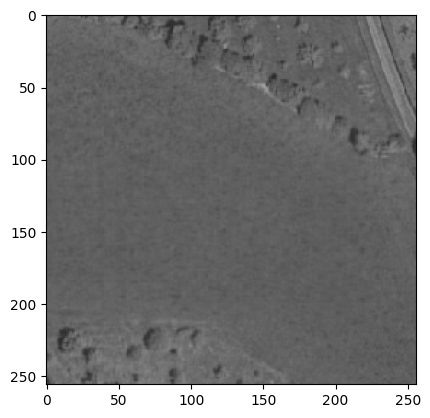

In [9]:
plt.imshow(imgs_test[0])

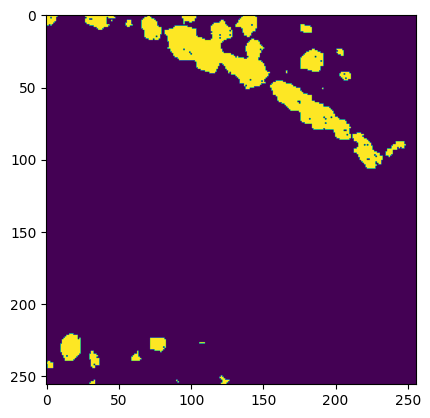

In [10]:
plt.imshow(imgs_mask_test[0])

In [11]:
def load_image(input_image, input_mask, image_size=64):
    input_image = tf.image.resize(input_image, (image_size*4, image_size*4))
    input_mask = tf.image.resize(input_mask, (image_size*4, image_size*4))

    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.cast(tf.squeeze(input_mask), dtype=tf.uint8)}

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((imgs_train, imgs_mask_train))
test_ds = tf.data.Dataset.from_tensor_slices((imgs_test, imgs_mask_test))

In [13]:
auto = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .shuffle(BS * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(BS)
    .prefetch(auto)
)
test_ds = (
    test_ds
    .map(load_image, num_parallel_calls=auto)
    .batch(BS)
    .prefetch(auto)
)


In [14]:
train_ds

<_PrefetchDataset element_spec={'pixel_values': TensorSpec(shape=(None, 3, 256, 256), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None)}>

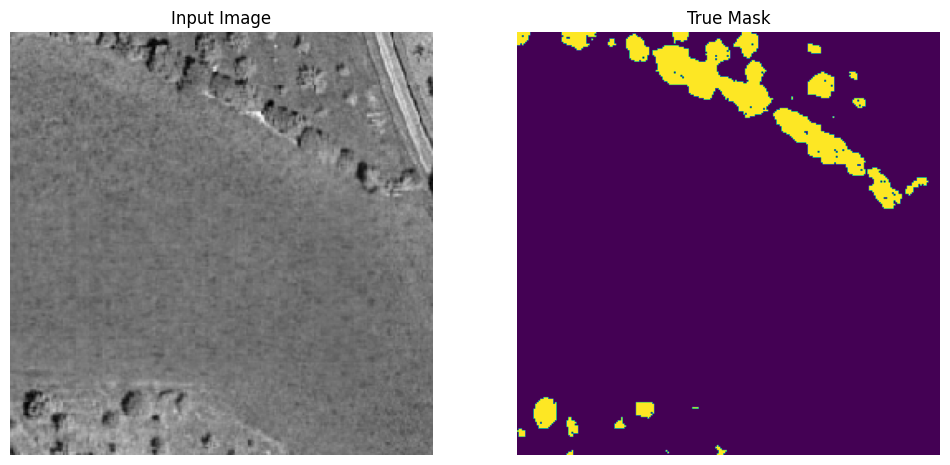

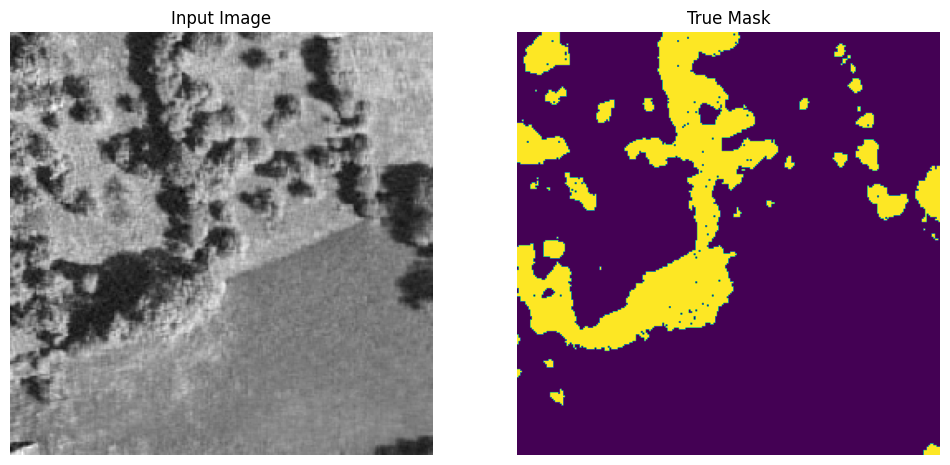

In [15]:
for samples in test_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    
    display([sample_image, sample_mask])

In [16]:
from transformers import TFSegformerForSemanticSegmentation# , TFSwinForMaskedImageModeling

model_checkpoint = "nvidia/mit-b0" # "facebook/maskformer-swin-base-ade"# "nvidia/mit-b0" "facebook/mask2former-swin-small-ade-semantic"
id2label = {0: "background", 1: "foreground"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print(model.summary())

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  395778    
 codeHead)                                                       
                                                                 
Total params: 3715170 (14.17 MB)
Trainable params: 3714658 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________
None


In [18]:
LR = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer)
callbacks = [DisplayCallback(test_ds), 
             keras.callbacks.EarlyStopping(patience=3, start_from_epoch=5),
             # keras.callbacks.ModelCheckpoint(config['models_dir']+f"intermediary_SegFormer_B&W_{int(len(imgs_train))}_trains_no_equalizing_with_normalizing_with_noise_{epochnum}_epochs_img_size_{img_size}_LR_{LR}_BS_4".replace('.', '_').replace('-','_'), save_best_only=True)
]

In [19]:
len(train_ds)

20

1/1 [==============================] - 1s 664ms/step


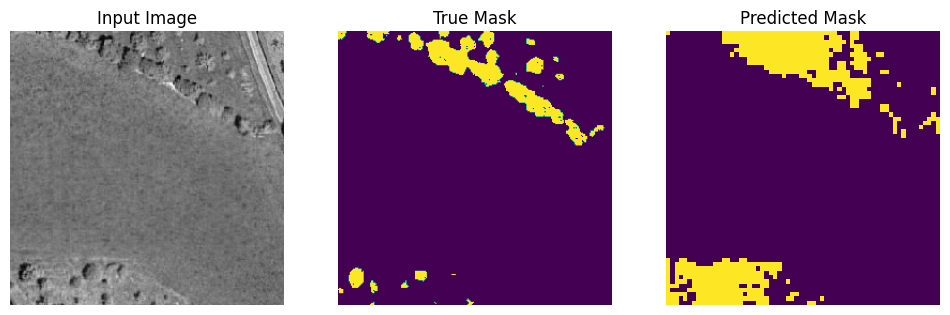


Sample Prediction after epoch 2

20/20 [==============================] - 38s 2s/step - loss: 0.6030 - val_loss: 0.5034


In [20]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=callbacks,
    epochs=2# epochnum, # Mettre 10
)


In [ ]:
model.save_pretrained((config['models_dir'] + 'SegFormer_B&W_' + str(int(len(imgs_train))) + '_trains' + '_epochs-' + str(epochnum) + f'_no_equalizing_with_normalizing_with_1_5_SVD_noise_img_size_{img_size}_LR_{LR}_BS_{BS}').replace('.', '_').replace('-','_'))

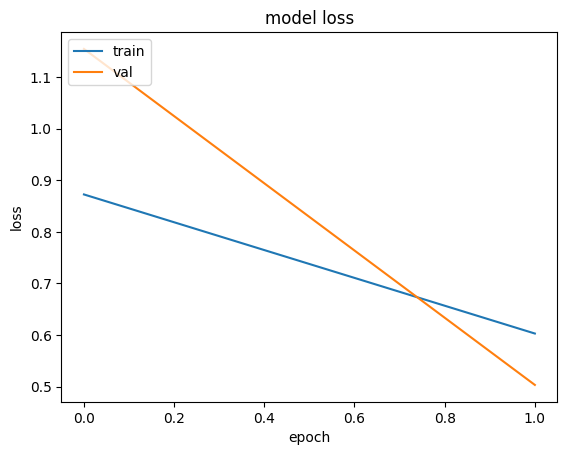

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
model_path = "output_models/SegFormer_B&W_8000_trains_epochs_10_no_equalizing_with_normalizing_with_2_noise_img_size_256_LR_6e_05_BS_4"
loaded_model = TFSegformerForSemanticSegmentation.from_pretrained(model_path,
                                                                  local_files_only=True)


All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at output_models/SegFormer_B&W_8000_trains_epochs_10_no_equalizing_with_normalizing_with_2_noise_img_size_256_LR_6e_05_BS_4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [31]:
LR = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
loaded_model.compile(optimizer=optimizer)

In [32]:
loaded_model.summary()

Model: "tf_segformer_for_semantic_segmentation_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  3319392   
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  395778    
 codeHead)                                                       
                                                                 
Total params: 3715170 (14.17 MB)
Trainable params: 3714658 (14.17 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [33]:
val_preds = loaded_model.predict(test_ds)

500/500 [==============================] - 327s 647ms/step


1/1 [==============================] - 5s 5s/step


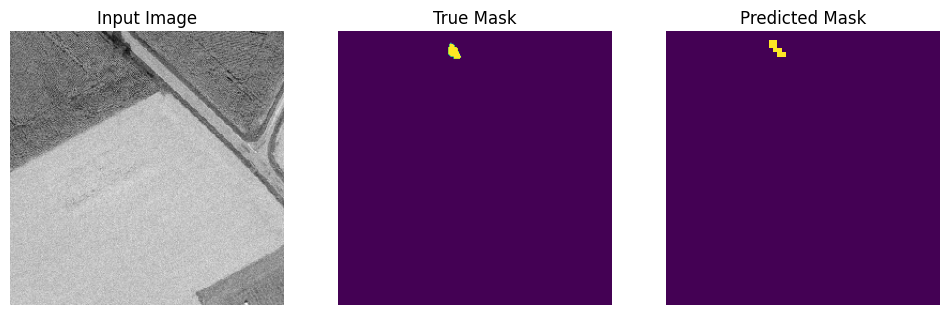

1/1 [==============================] - 1s 642ms/step


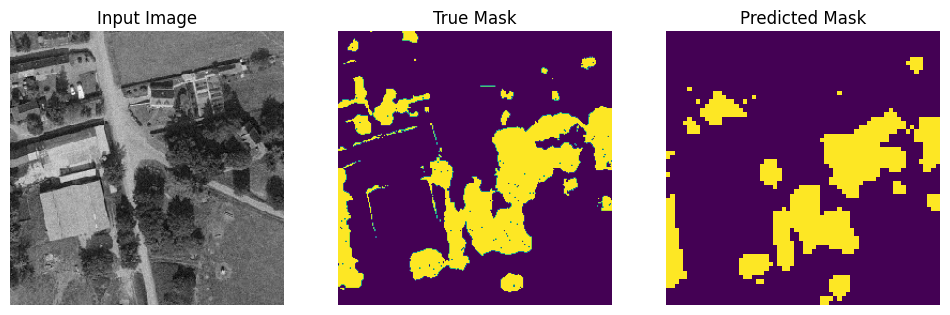

1/1 [==============================] - 1s 647ms/step


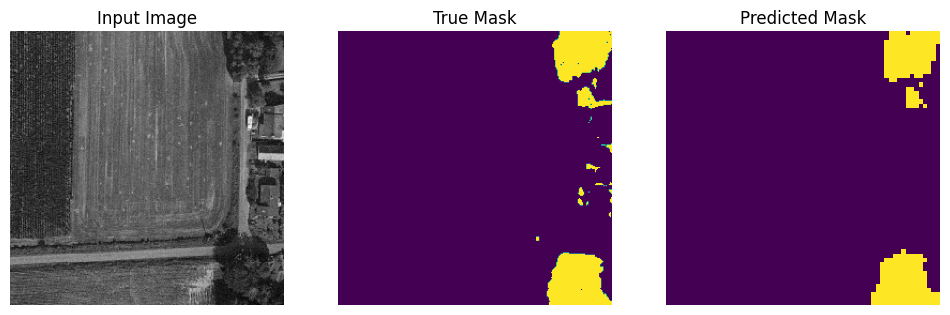

1/1 [==============================] - 1s 662ms/step


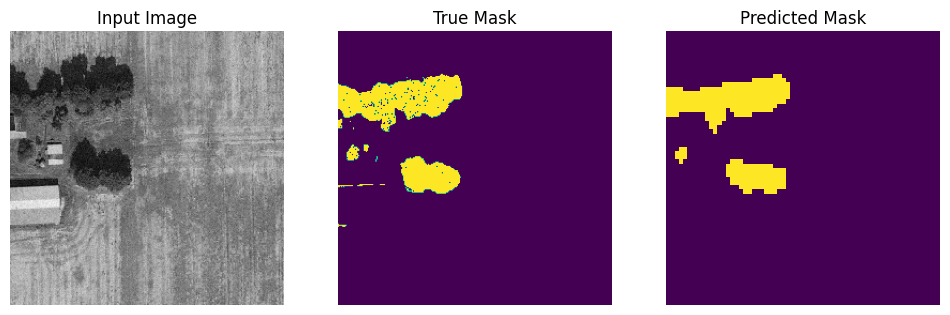

1/1 [==============================] - 1s 661ms/step


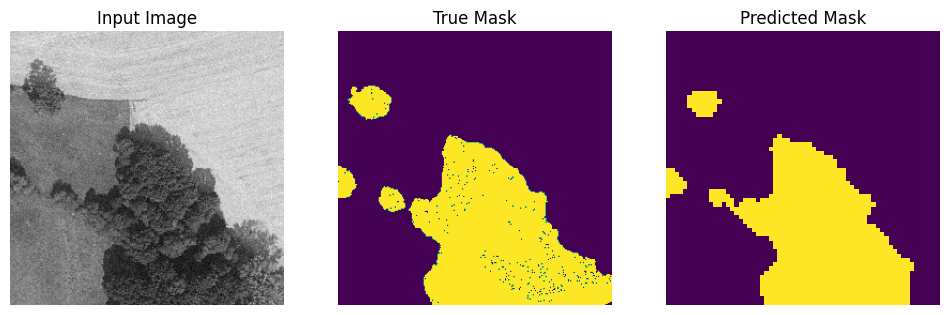

1/1 [==============================] - 1s 660ms/step


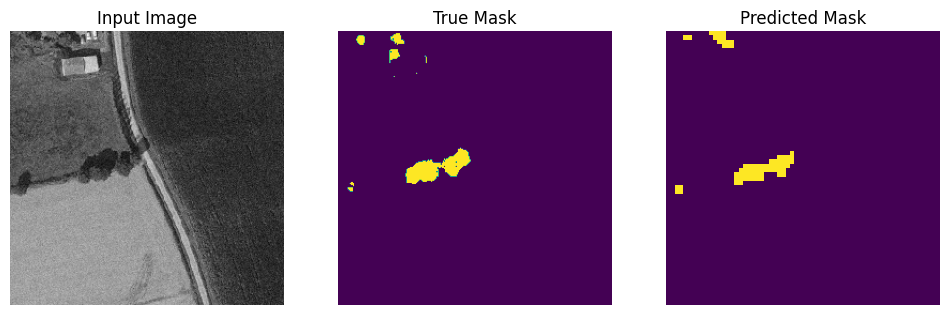

1/1 [==============================] - 1s 688ms/step


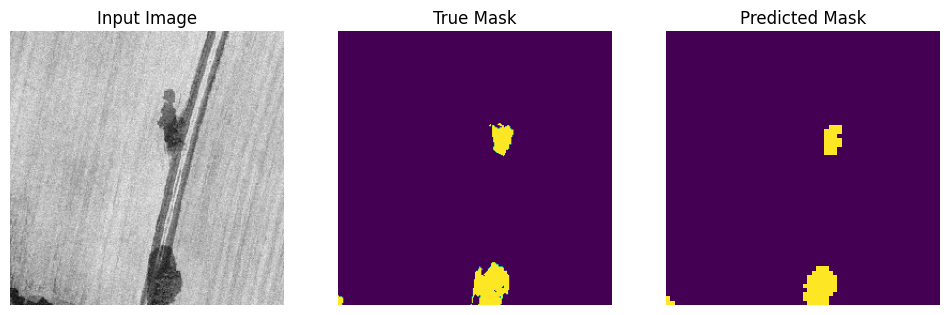

1/1 [==============================] - 1s 659ms/step


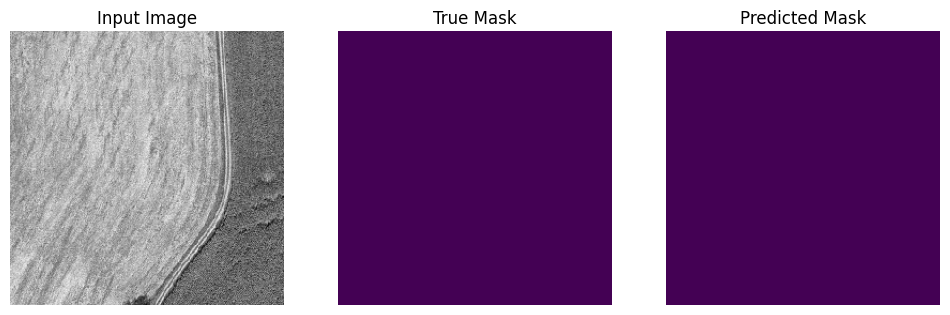

1/1 [==============================] - 1s 671ms/step


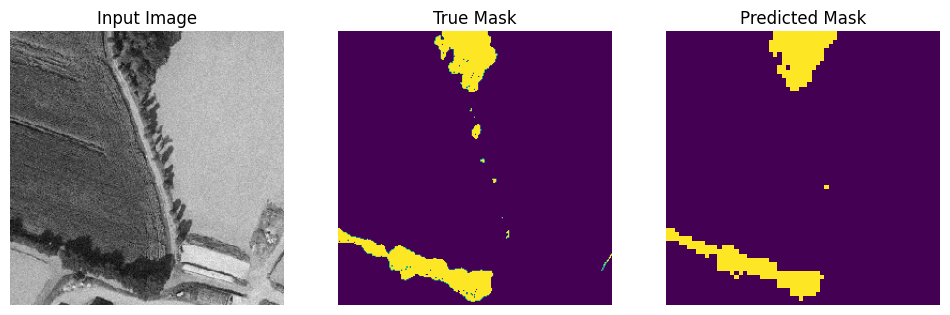

1/1 [==============================] - 1s 671ms/step


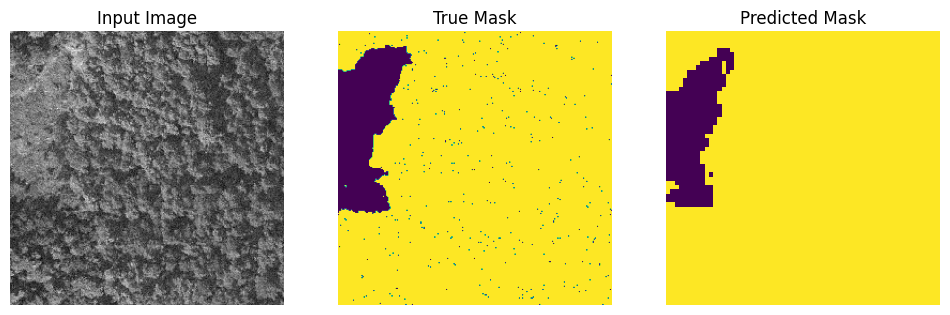

In [34]:
for sample in test_ds.take(10):
    images, masks = sample["pixel_values"], sample["labels"]
    masks = tf.expand_dims(masks, -1)
    pred_masks = loaded_model.predict(images).logits
    images = tf.transpose(images, (0, 2, 3, 1))
    display([images[0], masks[0], create_mask(pred_masks)])